In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from pprint import pprint

# time series specific
from sktime.forecasting.naive import NaiveForecaster
from sktime.utils.plotting import plot_series
from sktime.forecasting.model_selection import (
    ExpandingWindowSplitter,
    ForecastingGridSearchCV,
    SlidingWindowSplitter,
    CutoffSplitter,
    temporal_train_test_split,
)
from sktime.forecasting.model_evaluation import evaluate
from sktime.performance_metrics.forecasting import (
    # functions
    mean_absolute_error,
    mean_absolute_percentage_error,
    mean_absolute_scaled_error,
    mean_squared_error,
    mean_squared_scaled_error,
    # classes
    MeanAbsoluteError,
    MeanAbsolutePercentageError,
    MeanAbsoluteScaledError,
    MeanSquaredError,
    MeanSquaredScaledError,
)

from dsf_utils.preprocessing import process_raw_data, single_region_ts
# custom model from:
# https://www.sktime.org/en/latest/developer_guide/add_estimators
from dsf_utils.models import ConstantValueForecaster

# warnings
import warnings
warnings.filterwarnings('ignore')

plt.rcParams.update({'figure.figsize': (20,10)})
# set the numpy seed
np.random.seed(99)

# Datasets

## Synthetic Data

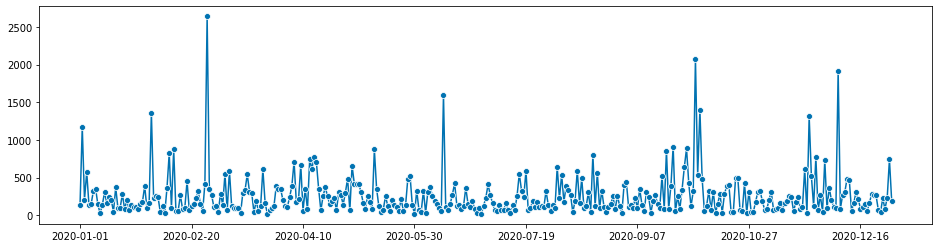

In [3]:
synthetic_data = pd.Series(
    10 + np.random.lognormal(5, 1, 365),
    index = pd.PeriodIndex(pd.date_range(start="2020-01-01", freq="D", periods=365), freq="D"), 
)

plot_series(synthetic_data)
plt.show()

## California ILI total

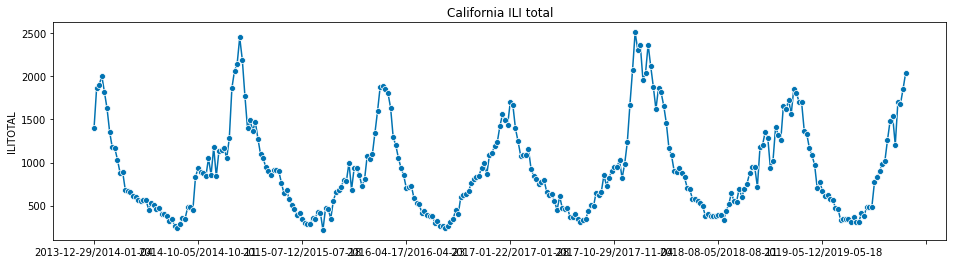

In [4]:
# California time series
main_df = pd.read_csv("../DATA/ILINet.csv", na_values="X")
main_df = process_raw_data(main_df)
real_ts = single_region_ts(main_df, region="California")
plot_series(real_ts)
plt.title("California ILI total")
plt.show()

# Naive forecasting methods

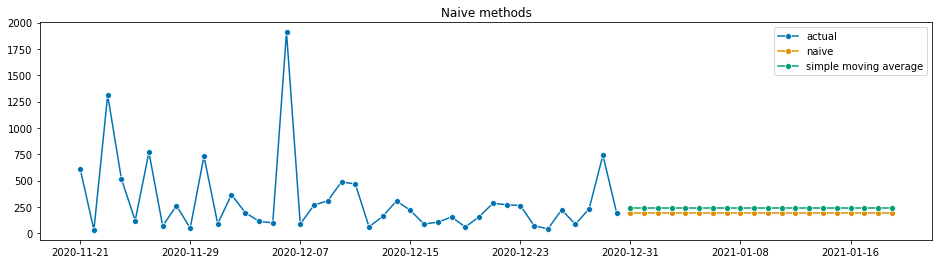

In [5]:
naive_fcaster = NaiveForecaster(strategy="last", sp=1)
sma_fcaster = NaiveForecaster(strategy="mean", sp=1, window_length=10)
naive_fcaster.fit(synthetic_data)
sma_fcaster.fit(synthetic_data)
# true_median_fcaster = ConstantValueForecaster(constant=10+lognormal_median(5))
# true_mean_fcaster = ConstantValueForecaster(constant=10+lognormal_mean(5,1))

# true_median_fcaster.fit(synthetic_data)
# true_mean_fcaster.fit(synthetic_data)
fh = np.arange(20)+1
plot_series(
    synthetic_data.iloc[-40:],
    naive_fcaster.predict(fh),
    sma_fcaster.predict(fh),
#     true_median_fcaster.predict(fh),
#     true_mean_fcaster.predict(fh),
    labels = ["actual", "naive", "simple moving average"]
)
plt.title("Naive methods")
plt.show()

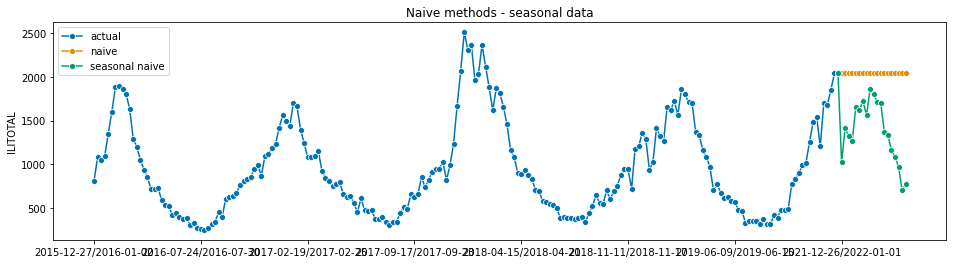

In [6]:
naive_fcaster = NaiveForecaster(strategy="last", sp=1)
seasonal_naive_fcaster = NaiveForecaster(strategy="last", sp=52)
naive_fcaster.fit(real_ts)
seasonal_naive_fcaster.fit(real_ts)
fh = np.arange(20)+104
plot_series(
    real_ts.iloc[104:],
    naive_fcaster.predict(fh),
    seasonal_naive_fcaster.predict(fh),
    labels = ["actual", "naive", "seasonal naive"]
)
plt.title("Naive methods - seasonal data")
plt.show()

# Evaluating performance

In the cases below we'll use **Mean Absolute Precentage Error - MAPE** as the forecasting performance KPI:  

$\Large MAPE = \frac{1}{h}\Sigma_{i=T+1}^{T+h}\frac{|y_i - \hat{y_i}|}{y_i} $  

MAPE is a very common forecasting metric due to its interpretability and scale free properties. We'll compare it with other forecasting metrics in the next section.

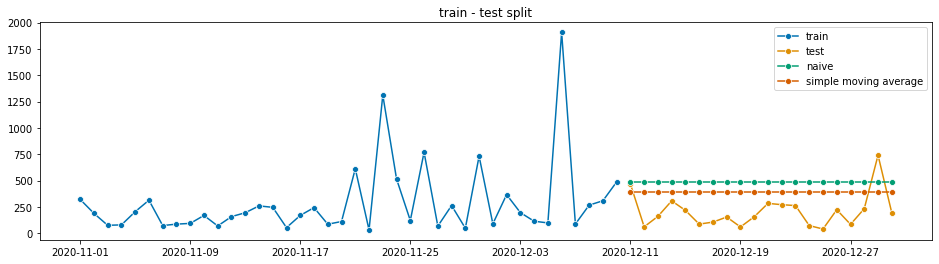

Naive MAPE =  297.08%
Simple Moving Average MAPE =  222.95%


In [7]:
# temporal train test splits
naive_fcaster = NaiveForecaster(strategy="last", sp=1)
sma_fcaster = NaiveForecaster(strategy="mean", sp=1, window_length=10)

# train test splits
y_train, y_test = temporal_train_test_split(synthetic_data, test_size=20)
naive_fcaster.fit(y_train)
sma_fcaster.fit(y_train)
fh = np.arange(20)+1
naive_pred = naive_fcaster.predict(fh)
sma_pred = sma_fcaster.predict(fh)

plot_series(
    y_train.iloc[-40:],
    y_test,
    naive_pred,
    sma_pred,
    labels = ["train", "test", "naive", "simple moving average"]
)
plt.title("train - test split")
plt.show()

mape_naive = mean_absolute_percentage_error(y_test, naive_pred, symmetric=False)*100
mape_sma = mean_absolute_percentage_error(y_test, sma_pred, symmetric=False)*100
print(f"Naive MAPE = {mape_naive: 0.2f}%")
print(f"Simple Moving Average MAPE = {mape_sma: 0.2f}%")

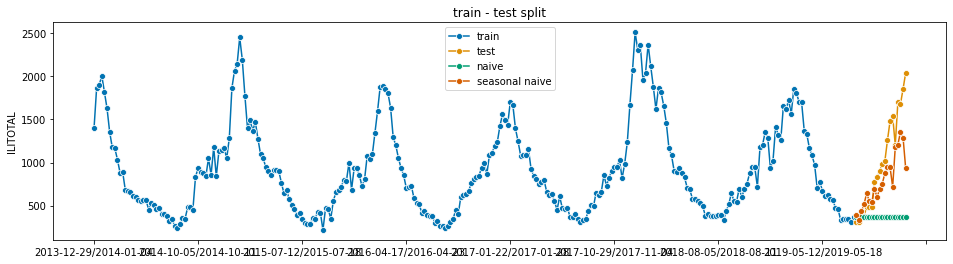

Naive MAPE =  51.17%
Seasonal Naive MAPE =  24.15%


In [8]:
# train test splits
y_train, y_test = temporal_train_test_split(real_ts, test_size=20)

naive_fcaster = NaiveForecaster(strategy="last", sp=1)
seasonal_naive_fcaster = NaiveForecaster(strategy="last", sp=52)
fh = np.arange(20)+1
naive_fcaster.fit(y_train)
seasonal_naive_fcaster.fit(y_train)
naive_pred = naive_fcaster.predict(fh)
seasonal_naive_pred = seasonal_naive_fcaster.predict(fh)

fh = np.arange(20)+1

plot_series(
    y_train,
    y_test,
    naive_pred,
    seasonal_naive_pred,
    labels = ["train", "test", "naive", "seasonal naive"]
)
plt.title("train - test split")
plt.show()

mape_naive = mean_absolute_percentage_error(y_test, naive_pred, symmetric=False)*100
mape_seasonal_naive = mean_absolute_percentage_error(y_test, seasonal_naive_pred, symmetric=False)*100
print(f"Naive MAPE = {mape_naive: 0.2f}%")
print(f"Seasonal Naive MAPE = {mape_seasonal_naive: 0.2f}%")

# Time series cross-validation

Maybe we were just unlucky (or lucky) above.  
To increase our confidence in our estimates for our MAPE we need to evaluate MAPE in many validation splits. 

**Cross Validation:**  
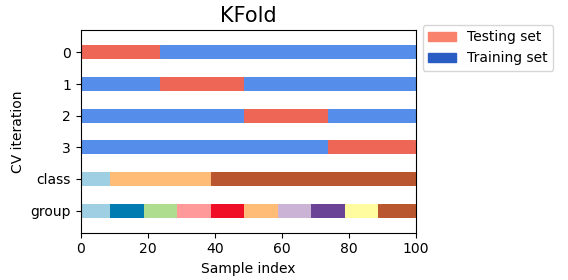

**Time Series Cross-Validation:**
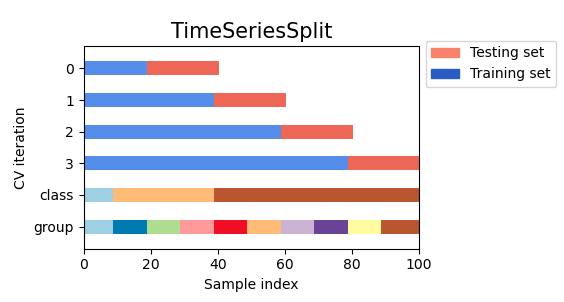

*images from:*  
1. https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html#sphx-glr-auto-examples-model-selection-plot-cv-indices-py

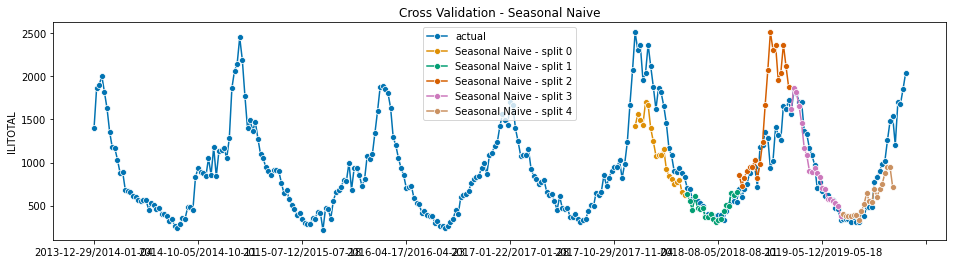

mean MAPE across CV splits is  22.00%


In [9]:
cv = ExpandingWindowSplitter(
    step_length=20, 
    fh=np.arange(20)+1, 
    initial_window=4*52,
    start_with_window = True
)

df = evaluate(
    forecaster=NaiveForecaster(strategy="last", sp=52), 
    y=real_ts, 
    cv=cv, 
    strategy="refit", 
    return_data=True,
    scoring=MeanAbsolutePercentageError(symmetric=False)
)

plot_series(
    real_ts,
    df["y_pred"].iloc[0],
    df["y_pred"].iloc[1],
    df["y_pred"].iloc[2],
    df["y_pred"].iloc[3],
    df["y_pred"].iloc[4], 
    labels = ["actual"]+[f"Seasonal Naive - split {i}" for i in range(len(df))]
)
plt.title("Cross Validation - Seasonal Naive")
plt.show()

mean_mape = df["test_MeanAbsolutePercentageError"].mean()*100
print(f"mean MAPE across CV splits is {mean_mape: 0.2f}%")

We might also want to test specific points in the past.  
With sktime we can create **custom cutoff** cross validation splits.

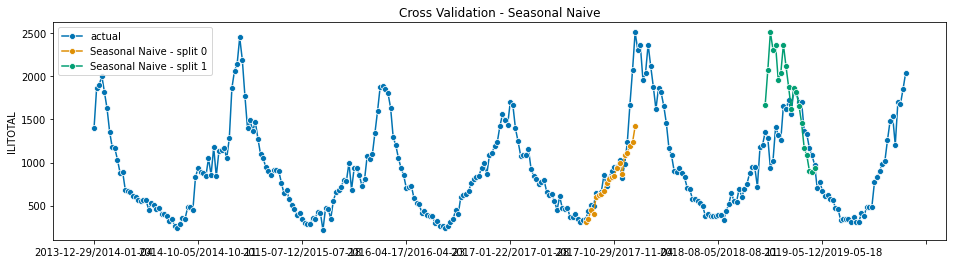

mean MAPE across CV splits is  24.95%


In [10]:
custom_cutoffs = np.array([
    len(real_ts[real_ts.index <= date]) for date in ["2017-08-01", "2018-12-01"]
])

cv = CutoffSplitter(
    cutoffs=custom_cutoffs, 
    fh=np.arange(20)+1, 
    window_length=4*52,
)

df = evaluate(
    forecaster=NaiveForecaster(strategy="last", sp=52), 
    y=real_ts, 
    cv=cv, 
    strategy="refit", 
    return_data=True,
    scoring=MeanAbsolutePercentageError(symmetric=False)
)

plot_series(
    real_ts,
    df["y_pred"].iloc[0],
    df["y_pred"].iloc[1],
    labels = ["actual"]+[f"Seasonal Naive - split {i}" for i in range(len(df))]
)
plt.title("Cross Validation - Seasonal Naive")
plt.show()

mean_mape = df["test_MeanAbsolutePercentageError"].mean()*100
print(f"mean MAPE across CV splits is {mean_mape: 0.2f}%")

# Forecasting metrics (point forecasts only)

### Scale Dependent Error Metrics

Root Mean Squared Error:

$\Large RMSE = \sqrt{\frac{1}{h}\Sigma_{t=T+1}^{T+h}(y_t - \hat{y_t})^{2}} $   

Mean Absolute Error:

$\Large MAE = \frac{1}{h}\Sigma_{t=T+1}^{T+h}|y_t - \hat{y_t}| $   

### Percentage Error Metrics

Mean Absolute Percentage Error:

$\Large MAPE = \frac{1}{h}\Sigma_{t=T+1}^{T+h}\frac{|y_t - \hat{y_t}|}{y_t} $  

Symmetric Mean Absolute Percentage Error:

$\Large sMAPE = \frac{200}{h}\Sigma_{t=T+1}^{T+h}\frac{|y_t - \hat{y_t}|}{|y_t + \hat{y_t}|} $  

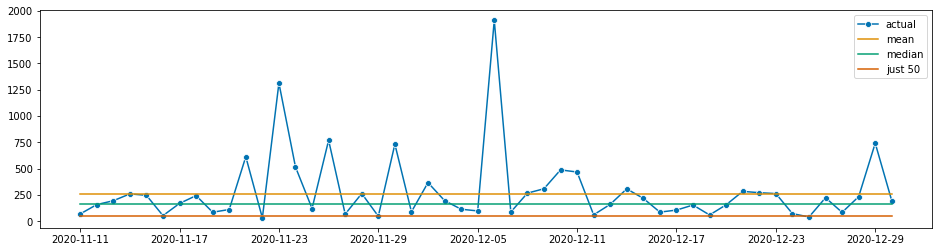

Metric,MAE,MAPE,RMSE,sMAPE
Forecaster,,,,
just 50,220.82,0.64,331.57,1.02
mean,188.51,1.44,263.58,0.72
median,178.87,0.86,273.60,0.69


In [11]:
cv = ExpandingWindowSplitter(
    step_length=20, 
    fh=np.arange(20)+1, 
    initial_window=200,
)

# lognormal stats functions:
lognormal_mean = lambda m, s: np.exp(m+((s**2)/2))
lognormal_median = lambda m: np.exp(m)

small_number = 50
forecasters_dict = {
    "mean": ConstantValueForecaster(10+lognormal_mean(5,1)),
    "median": ConstantValueForecaster(10+lognormal_median(5)),
    f"just {small_number}": ConstantValueForecaster(small_number)
}

metrics_dict = {
    "RMSE": MeanSquaredError(square_root=True),
    "MAE": MeanAbsoluteError(),
    "MAPE": MeanAbsolutePercentageError(symmetric=False),
    "sMAPE": MeanAbsolutePercentageError(symmetric=True)
}

df = pd.DataFrame()
for fcaster_name, forecaster in forecasters_dict.items():
    for metric_name, metric in metrics_dict.items():
        _df = evaluate(
            forecaster=forecaster, 
            y=synthetic_data, 
            cv=cv, 
            strategy="refit", 
            return_data=True,
            scoring=metric
        )
        score = np.mean(_df.iloc[:, 0])
        df = df.append(
            {"Forecaster": fcaster_name, "Metric": metric_name, "Score": score}, 
            ignore_index=True
        )

plot_series(
    synthetic_data.iloc[-50:],
    *[forecaster.predict(synthetic_data.iloc[-50:].index) for forecaster in forecasters_dict.values()],
    labels = ["actual"]+[name for name in forecasters_dict.keys()],
    markers=["o"]+[""]*len(forecasters_dict)
)
plt.show()        

results = df.pivot(
        index="Forecaster", 
        columns="Metric", 
        values="Score"
)

def highlight_min(s, props=''):
    return np.where(s == np.nanmin(s.values), props, '')

display(
    results
    .applymap('{:,.2f}'.format)
    .style
    .apply(highlight_min, props='color:white;background-color:purple', axis=0)
)

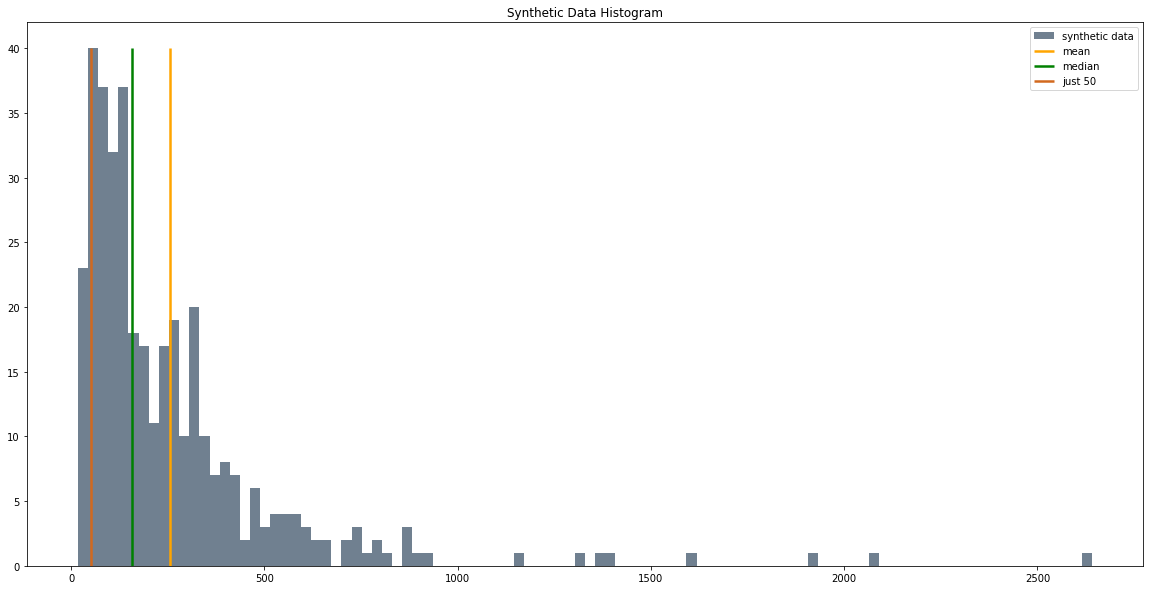

In [12]:
plt.hist(synthetic_data, color='slategrey', bins=100, label="synthetic data")
plt.axvline(10+lognormal_mean(5, 1), color="orange", linewidth=2.5, label="mean")
plt.axvline(10+lognormal_median(5), color="green", linewidth=2.5, label="median")
plt.axvline(small_number, color="chocolate", linewidth=2.5, label=f"just {small_number}")
plt.title("Synthetic Data Histogram")
plt.legend()
plt.show()

### OK - but why?

The task above can be described as - what is the constant value that minimises each metric?  

## RMSE 

Minimising the MSE is equivalent to minimising the RMSE.  

$\Large MSE = \frac{1}{h}\Sigma_{t=T+1}^{T+h}(y_t - x)^{2} $  

Minimise MSE by setting its derivative to zero:  

$\Large \frac{\partial}{\partial x} MSE= 0 $  

$\Large \Rightarrow \frac{\partial}{\partial x}\frac{1}{h}\Sigma_{t=T+1}^{T+h}(y_t - x)^{2} = 0$  

$\Large \Rightarrow \frac{-1}{h}\Sigma_{t=T+1}^{T+h}\frac{\partial}{\partial x}(y_t - x)^{2} = 0$  

$\Large \Rightarrow \frac{1}{h}\Sigma_{t=T+1}^{T+h}2(y_t - x) = 0$  

$\Large \Rightarrow \frac{1}{h}\Sigma_{t=T+1}^{T+h}x = \frac{1}{h}\Sigma_{t=T+1}^{T+h}y_t $  

$\Large \Rightarrow x = \frac{1}{h}\Sigma_{t=T+1}^{T+h}y_t$  

## MAE

$\Large \frac{\partial}{\partial x} MAE= 0 $  

$\Large \Rightarrow \frac{\partial}{\partial x} \frac{1}{h}\Sigma_{t=T+1}^{T+h}|y_t - x| = 0$  

$\Large \Rightarrow \frac{-1}{h}\Sigma_{t=T+1}^{T+h}\frac{\partial}{\partial x}|y_t - x| = 0$  

$\Large \Rightarrow \frac{1}{h}\Sigma_{t=T+1}^{T+h}\frac{(y_t - x)}{|y_t - x|} = 0$  

$\Large \frac{(y_t - x)}{|y_t - x|} = \begin{cases}
    1,& \text{if } x < y_t \\
    -1,& \text{if } x > y_t \\
\end{cases} $

Therefore MAE is minimised when $y_t$ is equal number of times larger and smaller than $x$, a condition satisfied by the median.

## MAPE & sMAPE

*It's complicated*

**Some good reads on this:**
* [Forecasting Principles and Practice - Section 5.8](https://otexts.com/fpp3/accuracy.html)
* [Stephan Kolassa answer on stackexchange - the shortcomings of MAPE](https://stats.stackexchange.com/questions/299712/what-are-the-shortcomings-of-the-mean-absolute-percentage-error-mape/299713#299713)
* [Stephan Kolassa answer on stackexchange - Why does minimizing the MAE lead to forecasting the median and not the mean?](https://stats.stackexchange.com/questions/355538/why-does-minimizing-the-mae-lead-to-forecasting-the-median-and-not-the-mean)
* [Nicolas Vandeput - Forecast KPIs: RMSE, MAE, MAPE & Bias](https://towardsdatascience.com/forecast-kpi-rmse-mae-mape-bias-cdc5703d242d)

### Scaled Error Metrics

Root Mean Squared Scaled Error:

$\LARGE RMSSE = \sqrt{\frac{\frac{1}{h}\Sigma_{i=T+1}^{T+h}(y_t - \hat{y_t})^{2}}
{\frac{1}{T-1}\Sigma_{i=2}^{T}(y_t - y_{t-1})^{2}}} $   

Mean Absolute Scaled Error:

$\LARGE MASE = \frac{\frac{1}{h}\Sigma_{t=T+1}^{T+h}|y_t - \hat{y_t}|}
{\frac{1}{T-1}\Sigma_{t=2}^{T}|y_t - y_{t-1}|} $   

In a more visual way:  
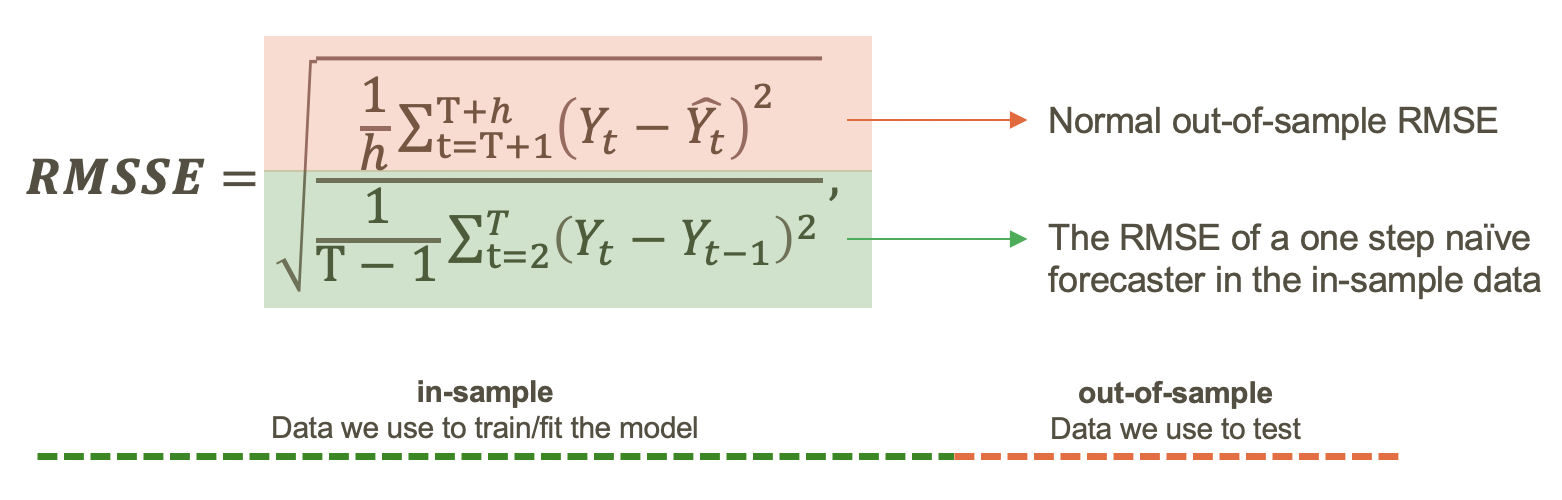

### Scaled Error Metrics - Seasonal Variants


$\LARGE RMSSE = \sqrt{\frac{\frac{1}{h}\Sigma_{t=T+1}^{T+h}(y_t - \hat{y_t})^{2}}
{\frac{1}{T-m}\Sigma_{t=2}^{T}(y_t - y_{t-m})^{2}}} $   


$\LARGE MASE = \frac{\frac{1}{h}\Sigma_{t=T+1}^{T+h}|y_t - \hat{y_t}|}
{\frac{1}{T-m}\Sigma_{t=2}^{T}|y_t - y_{t-m}|} $   

where $ m $ is the seasonal period

In [13]:
cv = ExpandingWindowSplitter(
    step_length=20, 
    fh=np.arange(20)+1, 
    initial_window=200,
)

small_number = 50
forecasters_dict = {
    "mean": ConstantValueForecaster(10+lognormal_mean(5,1)),
    "median": ConstantValueForecaster(10+lognormal_median(5)),
    f"just {small_number}": ConstantValueForecaster(small_number)
}

metrics_dict = {
    "RMSE": MeanSquaredError(square_root=True),
    "RMSSE": MeanSquaredScaledError(square_root=True),
    "MAE": MeanAbsoluteError(),
    "MASE": MeanAbsoluteScaledError(),
    "MAPE": MeanAbsolutePercentageError(symmetric=False),
    "sMAPE": MeanAbsolutePercentageError(symmetric=True),
}

df = pd.DataFrame()
for fcaster_name, forecaster in forecasters_dict.items():
    for metric_name, metric in metrics_dict.items():
        _df = evaluate(
            forecaster=forecaster, 
            y=synthetic_data, 
            cv=cv, 
            strategy="refit", 
            return_data=True,
            scoring=metric
        )
        score = np.mean(_df.iloc[:, 0])
        df = df.append(
            {"Forecaster": fcaster_name, "Metric": metric_name, "Score": score}, 
            ignore_index=True
        )    

results = df.pivot(
        index="Forecaster", 
        columns="Metric", 
        values="Score"
)

display(
    results
    .applymap('{:,.2f}'.format)
    .style
    .apply(highlight_min, props='color:white;background-color:purple', axis=0)
)

Metric,MAE,MAPE,MASE,RMSE,RMSSE,sMAPE
Forecaster,,,,,,
just 50,220.82,0.64,0.96,331.57,0.87,1.02
mean,188.51,1.44,0.82,263.58,0.69,0.72
median,178.87,0.86,0.78,273.60,0.72,0.69


For the next sections we'll use **RMSSE** as the main KPI